In [1]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation
train_h5_path = "data/food41/food_c101_n10099_r64x64x3.h5"
test_h5_path = "data/food41/food_test_c101_n1000_r64x64x3.h5"

Using TensorFlow backend.


In [2]:
#Load the training
X_train = HDF5Matrix(train_h5_path, 'images')
y_train = HDF5Matrix(train_h5_path, 'category')
print('In Data',X_train.shape,'=>', y_train.shape)

In Data (10099, 64, 64, 3) => (10099, 101)


In [3]:
#Load the test data
X_test = HDF5Matrix(test_h5_path, 'images')
y_test = HDF5Matrix(test_h5_path, 'category')
print('In Data',X_test.shape,'=>', y_test.shape)

In Data (1000, 64, 64, 3) => (1000, 101)


C:\Users\Admin\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


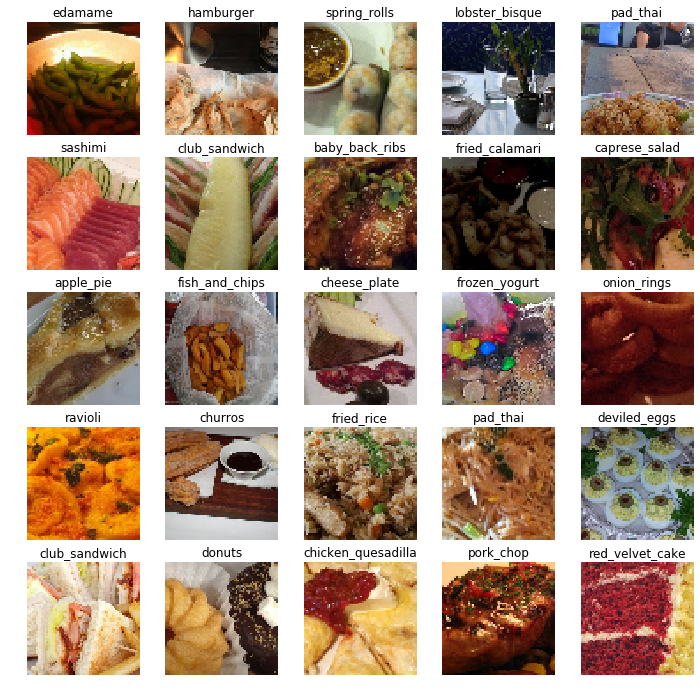

In [4]:
sample_imgs = 25
with h5py.File(train_h5_path, 'r') as n_file:
    total_imgs = n_file['images'].shape[0]
    read_idxs = slice(0,sample_imgs)
    im_data = n_file['images'][read_idxs]
    im_label = n_file['category'].value[read_idxs]
    label_names = [x.decode() for x in n_file['category_names'].value]
fig, m_ax = plt.subplots(5, 5, figsize = (12, 12))
for c_ax, c_label, c_img in zip(m_ax.flatten(), im_label, im_data):
    c_ax.imshow(c_img if c_img.shape[2]==3 else c_img[:,:,0], cmap = 'gray')
    c_ax.axis('off')
    c_ax.set_title(label_names[np.argmax(c_label)])

In [5]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(y_test.shape[1]))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

loss_history = []
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)  

In [6]:
for i in range(10):
    loss_history += [model.fit(X_train, y_train,
                               validation_data=(X_test, y_test), 
                               batch_size = 256,
                               epochs = 1, shuffle="batch")]

Instructions for updating:
Use tf.cast instead.
Train on 10099 samples, validate on 1000 samples
Epoch 1/1
10099/10099 [==============================] - 56s 6ms/step - loss: 15.8960 - acc: 0.0108 - val_loss: 16.0375 - val_acc: 0.0050
Train on 10099 samples, validate on 1000 samples
Epoch 1/1
10099/10099 [==============================] - 40s 4ms/step - loss: 15.9031 - acc: 0.0113 - val_loss: 15.9569 - val_acc: 0.0100
Train on 10099 samples, validate on 1000 samples
Epoch 1/1
10099/10099 [==============================] - 40s 4ms/step - loss: 15.8818 - acc: 0.0132 - val_loss: 16.0214 - val_acc: 0.0060
Train on 10099 samples, validate on 1000 samples
Epoch 1/1
10099/10099 [==============================] - 41s 4ms/step - loss: 15.8822 - acc: 0.0134 - val_loss: 15.9582 - val_acc: 0.0090
Train on 10099 samples, validate on 1000 samples
Epoch 1/1
10099/10099 [==============================] - 41s 4ms/step - loss: 15.8473 - acc: 0.0158 - val_loss: 15.9253 - val_acc: 0.0120
Train on 10099 sa

Text(0.5, 1.0, 'Accuracy')

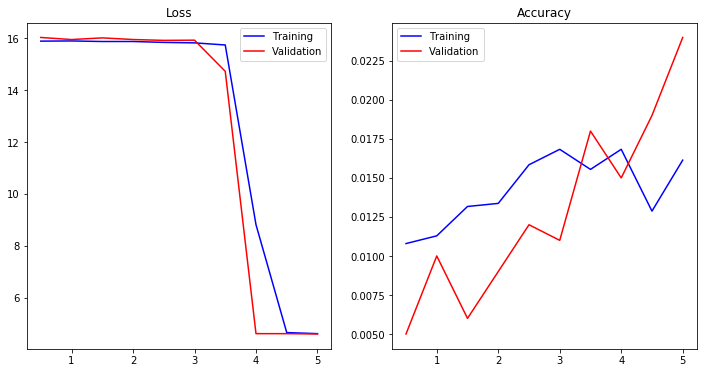

In [7]:
epich = np.cumsum(np.concatenate(
    [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = ax1.plot(epich,
             np.concatenate([mh.history['loss'] for mh in loss_history]),
             'b-',
             epich, np.concatenate(
        [mh.history['val_loss'] for mh in loss_history]), 'r-')
ax1.legend(['Training', 'Validation'])
ax1.set_title('Loss')

_ = ax2.plot(epich, np.concatenate(
    [mh.history['acc'] for mh in loss_history]), 'b-',
                 epich, np.concatenate(
        [mh.history['val_acc'] for mh in loss_history]),
                 'r-')
ax2.legend(['Training', 'Validation'])
ax2.set_title('Accuracy')

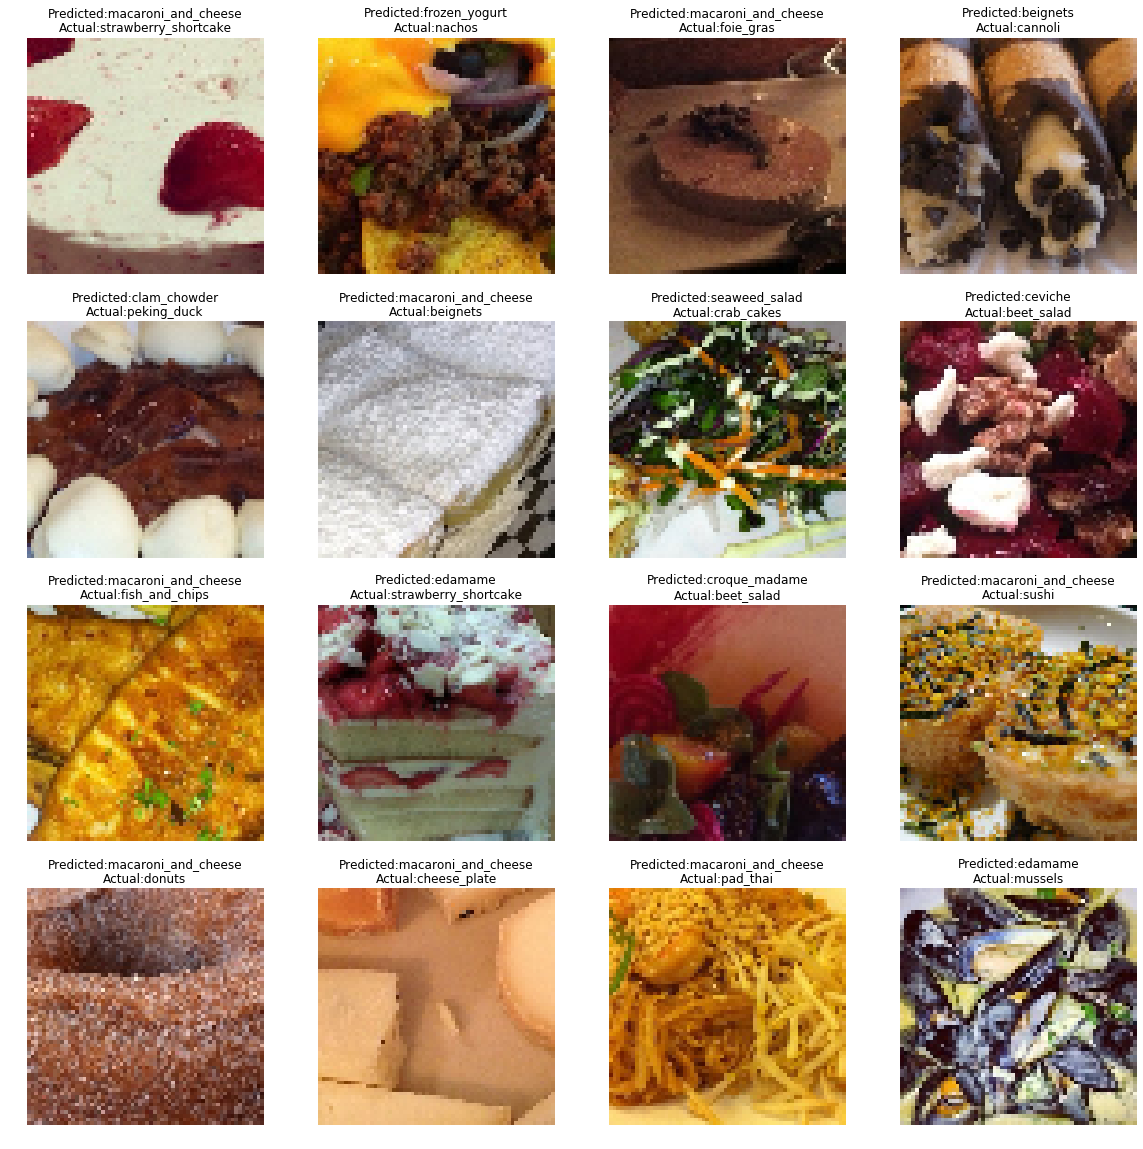

In [8]:
sample_imgs = 16
with h5py.File(test_h5_path, 'r') as n_file:
    total_imgs = n_file['images'].shape[0]
    read_idxs = slice(0,sample_imgs)
    im_data = n_file['images'][read_idxs]
    im_label = n_file['category'].value[read_idxs]
    label_names = [x.decode() for x in n_file['category_names'].value]
pred_label = model.predict(im_data)
fig, m_ax = plt.subplots(4, 4, figsize = (20, 20))
for c_ax, c_label, c_pred, c_img in zip(m_ax.flatten(), im_label, pred_label, im_data):
    c_ax.imshow(c_img if c_img.shape[2]==3 else c_img[:,:,0], cmap = 'gray')
    c_ax.axis('off')
    c_ax.set_title('Predicted:{}\nActual:{}'.format(label_names[np.argmax(c_pred)],
                                                  label_names[np.argmax(c_label)]))